# LIBRARIES

Installation and import of the necessary libraries

In [ ]:
#!pip install --quiet torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
import torch
import torch.optim as optim
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.models.segmentation as seg
import numpy as np
import os
from time import time
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
import random
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

# DATASETS DOWNLOADING

In [ ]:
t0 = time()

# Dataset paths
images_dir = os.path.join('/kaggle/input/im-and-la-dl/IMAGES/IMAGES')
labels_dir = os.path.join('/kaggle/input/im-and-la-dl/LABELS/LABELS')

print("File transfer completed in %0.2f seconds" % (time() - t0))
print(images_dir)
print("Images:", os.listdir(images_dir)[:5])
print('\n')
print(labels_dir)
print("Labels:", os.listdir(labels_dir)[:5])

File transfer completed in 0.00 seconds
/kaggle/input/im-and-la-dl/IMAGES/IMAGES
Images: ['0016E5_07770.png', '0001TP_009780.png', '0016E5_07963.png', '0001TP_008700.png', '0016E5_01920.png']


/kaggle/input/im-and-la-dl/LABELS/LABELS
Labels: ['0016E5_01440_L.png', '0016E5_08045_L.png', '0001TP_008010_L.png', '0006R0_f02010_L.png', '0001TP_008580_L.png']


# PREPROCESSING

This code prepares the CamVid dataset for semantic segmentation by mapping raw RGB label colors to class indices, merging similar classes into a reduced set of 12 categories, then 8, and building a dataset loader compatible with PyTorch training.

- Defines black pixels (0,0,0) as void.

- Maps RGB colors → class indices using the original CamVid color palette.

- Provides a function (rgb2index) to convert color labels into integer masks.

- Merges the original 12 classes into 8 aggregated classes (e.g. Parked bikes are merged into Vehicles).

- Implements a custom PyTorch Dataset class (CamVidDataset) that:

  - Loads images and their labels.

  - Converts labels from RGB to indices and remaps to the new 8 classes.

  - Applies augmentations with Albumentations (if specified).

  - Returns tensors ready for training.

In [ ]:
IGNORE_RGB   = (0, 0, 0)     # black pixels are now "void"
IGNORE_INDEX = 255           # label value used to ignore pixels in loss/metrics

label2index = {}

camvid_labelIDs = [
    [[128, 128, 128]],  # 0: Sky - Gray
    [                   # 1: Buildings
        [0, 128, 64],   # Dark Green - Bridge
        [128, 0, 0],    # Maroon - Building
        [192, 0, 128],  # Deep Pink - Gas Station / Roof
    ],
    [                   # 2: Poles and Cones
        [192, 192, 128],# Khaki - Pole
        [0, 0, 64],     # Navy - Cones
        [0, 64, 128],   # Steel Blue - Cones
    ],
    [                   # 3: Roads
        [128, 64, 128], # Medium Orchid - Road
        [128, 0, 192],  # Purple - Horizontal Signage
        [192, 0, 64],   # Crimson - Horizontal Signage
        [128, 128, 192],# Lavender Blue - Road
    ],
    [                   # 4: Pavements
        [0, 0, 192],    # Blue - Pavement
        [64, 192, 128], # Aquamarine - Traffic Island
    ],
    [[192, 192, 0]],    # 5: Bushes and Lawns - Yellow-Green
    [                   # 6: Vertical Signage
        [192, 128, 128],# Rosy Brown - Vertical Signage
        [128, 128, 64], # Olive Drab - Vertical Signage
        [0, 64, 64],    # Teal - Traffic Light
    ],
    [                   # 7: Fences
        [64, 64, 128],  # Slate Blue - Fence
        [64, 192, 0],   # Lime Green - Fence
    ],
    [                   # 8: Vehicles
        [64, 0, 128],   # Indigo - Vehicle
        [64, 0, 64],    # Dark Purple - Vehicle shade
        [64, 128, 192], # Sky Blue - Vehicle
        [192, 128, 192],# Orchid - Big Vehicle
        [192, 64, 128], # Medium Violet Red - Vehicle shade
        [192, 0, 192],  # Magenta - Parked Motorbike
        [0, 128, 192],  # Deep Sky Blue - Vehicle
    ],
    [[128, 64, 64]],    # 9: Parked Bikes - Brown
    [                   # 10: Pedestrians
        [64, 64, 0],    # Olive Green - Pedestrian
        [192, 128, 64], # Tan - Pedestrian
        [64, 0, 192],   # Dark Violet - Bag
        [64, 128, 64],  # Forest Green - Pedestrian
        [128, 128, 0],  # Olive - Pedestrian
    ],
    [[192, 128, 64]],   # 11: Animals - Tan
]

for class_index, color_group in enumerate(camvid_labelIDs):
    for rgb in color_group:
        label2index[tuple(rgb)] = class_index

NUM_CLASSES = len(camvid_labelIDs)

def rgb2index(label_img: np.ndarray) -> np.ndarray:

    h, w, _ = label_img.shape
    label_index = np.full((h, w), IGNORE_INDEX, dtype=np.uint8)

    for rgb, idx in label2index.items():
        mask = np.all(label_img == rgb, axis=-1)
        label_index[mask] = idx

    return label_index

class_merge_map = {
    0: 0,  # Sky -> Sky
    1: 1,  # Buildings -> Buildings
    2: 2,  # Poles & Cones -> Poles & Cones
    3: 3,  # Roads -> Roads
    4: 4,  # Pavements -> Pavements
    5: 5,  # Bushes & Lawns -> Vegetation
    6: 2,  # Vertical Signage -> Poles & Cones
    7: 2,  # Fences -> Poles & Cones
    8: 6,  # Vehicles -> Vehicles
    9: 6,  # Parked Bikes -> Vehicles
    10: 7, # Pedestrians -> Humans
    11: 7, # Animals -> Humans
}

NEW_NUM_CLASSES = 8

def remap_classes(label_img: np.ndarray) -> np.ndarray:
    """
    Rimappa le classi originali a un set ridotto di classi aggregate.
    Qualsiasi pixel non mappato o IGNORE_INDEX rimane IGNORE_INDEX.
    """
    new_label = np.full_like(label_img, IGNORE_INDEX)
    for orig_class, new_class in class_merge_map.items():
        mask = (label_img == orig_class)
        new_label[mask] = new_class

    return new_label

class CamVidDataset(Dataset):

    def __init__(self, images_dir, labels_dir, image_list, label_list,
                 transform=None, image_only_transform=None):

        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.images = image_list
        self.labels = label_list
        self.transform = transform
        self.image_only_transform = image_only_transform

    def __len__(self):

        return len(self.images)

    def __getitem__(self, index):

        img_name = self.images[index]
        lab_name = self.labels[index]

        img_path = os.path.join(self.images_dir, img_name)
        lab_path = os.path.join(self.labels_dir, lab_name)

        image = np.array(Image.open(img_path).convert('RGB'))
        label_rgb = np.array(Image.open(lab_path).convert('RGB'))

        label = rgb2index(label_rgb)
        label =remap_classes(label)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image, label = augmented['image'], augmented['mask']

        if self.image_only_transform:
            image = self.image_only_transform(image=image)['image']

        image = torch.tensor(image).permute(2, 0, 1).float()
        label = torch.tensor(label).long()

        return image, label

Here the splitting, augmentation, and organization of the CamVid dataset are handled. Frames from the same video sequence are proportionally distributed into training, testing and evaluation sets, while also applying augmentation to improve model generalization.

- Sets a random seed for reproducibility of splits.

- Collects all image files and automatically matches them with their label files.

- Groups images by their video sequence ID (to avoid mixing similar frames across splits).

- Splits each video group into train (60%), test (20%), and eval (20%) subsets.

- Defines two augmentation pipelines:

  - Advanced: flips, crops, resizing, rotations, brightness/contrast.

  - Basic: resizing, flipping, brightness/contrast.

- Creates CamVidDataset objects for train/test/eval with the chosen transformations.

- Counts images per video ID in each split and builds a summary DataFrame.

- Prints a table showing the split proportions and total counts.

In [ ]:
random.seed(42)

image_list = [f for f in os.listdir(images_dir) if f.endswith('.png')]
label_list = [f.split('.png')[0] + '_L.png' for f in image_list]

video_groups = defaultdict(list)
for f in image_list:
    video_id = f[:6]
    video_groups[video_id].append(f)

train_ratio = 0.6
test_ratio = 0.2
eval_ratio = 0.2

train_images, test_images, eval_images = [], [], []

for video_id, files in video_groups.items():

    random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_test = int(n * test_ratio)
    n_eval = n - n_train - n_test

    train_images.extend(files[:n_train])
    test_images.extend(files[n_train:n_train + n_test])
    eval_images.extend(files[n_train + n_test:])

train_labels = [f.split('.png')[0] + '_L.png' for f in train_images]
test_labels = [f.split('.png')[0] + '_L.png' for f in test_images]
eval_labels = [f.split('.png')[0] + '_L.png' for f in eval_images]

use_advanced_augmentation = True

if use_advanced_augmentation:

    shared_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomCrop(height=224, width=224, p=0.5),
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    ])

    image_only_transform = A.Compose([
        A.RandomBrightnessContrast(p=0.5),
    ])

    train_dataset = CamVidDataset(
        images_dir=images_dir,
        labels_dir=labels_dir,
        image_list=train_images,
        label_list=train_labels,
        transform=shared_transform,
        image_only_transform=image_only_transform
    )

    test_dataset = CamVidDataset(
        images_dir=images_dir,
        labels_dir=labels_dir,
        image_list=test_images,
        label_list=test_labels,
        transform=shared_transform,
        image_only_transform=image_only_transform
    )

    eval_dataset = CamVidDataset(
        images_dir=images_dir,
        labels_dir=labels_dir,
        image_list=eval_images,
        label_list=eval_labels,
        transform=shared_transform,
        image_only_transform=image_only_transform
    )

else:

    transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
    ])

    train_dataset = CamVidDataset(
        images_dir=images_dir,
        labels_dir=labels_dir,
        image_list=train_images,
        label_list=train_labels,
        transform=transform
    )

    test_dataset = CamVidDataset(
        images_dir=images_dir,
        labels_dir=labels_dir,
        image_list=test_images,
        label_list=test_labels,
        transform=transform
    )

    eval_dataset = CamVidDataset(
        images_dir=images_dir,
        labels_dir=labels_dir,
        image_list=eval_images,
        label_list=eval_labels,
        transform=transform
    )

def count_by_video_id(image_list):

    return Counter([img[:5] for img in image_list])

train_counts = count_by_video_id(train_images)
test_counts = count_by_video_id(test_images)
eval_counts = count_by_video_id(eval_images)

all_video_ids = sorted(set(train_counts) | set(test_counts) | set(eval_counts))

proportion_data = []

for vid in all_video_ids:

    total = train_counts[vid] + test_counts[vid] + eval_counts[vid]
    proportion_data.append({
        "Video ID": vid,
        "Train %": round(100 * train_counts[vid] / total, 1),
        "Test %": round(100 * test_counts[vid] / total, 1),
        "Eval %": round(100 * eval_counts[vid] / total, 1),
        "Total Images": total
    })

proportion_df = pd.DataFrame(proportion_data)
proportion_df.sort_values("Video ID", inplace=True)

summary_row = pd.DataFrame([{
    "Video ID": "TOTAL",
    "Train %": len(train_images),
    "Test %": len(test_images),
    "Eval %": len(eval_images),
    "Total Images": len(train_images) + len(test_images) + len(eval_images)
}])

proportion_df = pd.concat([proportion_df, summary_row], ignore_index=True)

print(proportion_df.to_string(index=False))

Video ID  Train %  Test %  Eval %  Total Images
   0001T     59.7    19.4    21.0           124
   0006R     59.4    19.8    20.8           101
   0016E     60.0    20.0    20.0           305
   Seq05     59.6    19.9    20.5           171
   TOTAL    419.0   139.0   143.0           701


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## IMAGES CHECK

This chunk has been made to check whether there are edits in the video or not.
Usually images are taken every 30 frames, but in the group '0016E', between '0016E5_07959.png' and '0016E5_08159.png', images are taken every 2 frames. So, we have 100 images that likely are very similar.

In [ ]:
def extract_last_five_digits(filename):
    match = re.search(r'(\d{5})\.png$', filename)
    return int(match.group(1)) if match else float('inf')

for video_id, files in video_groups.items():
    files.sort(key=extract_last_five_digits)
    video_groups[video_id] = files

display(video_groups)

defaultdict(list,
            {'0016E5': ['0016E5_00390.png',
              '0016E5_00420.png',
              '0016E5_00450.png',
              '0016E5_00480.png',
              '0016E5_00510.png',
              '0016E5_00540.png',
              '0016E5_00570.png',
              '0016E5_00600.png',
              '0016E5_00630.png',
              '0016E5_00660.png',
              '0016E5_00690.png',
              '0016E5_00720.png',
              '0016E5_00750.png',
              '0016E5_00780.png',
              '0016E5_00810.png',
              '0016E5_00840.png',
              '0016E5_00870.png',
              '0016E5_00901.png',
              '0016E5_00930.png',
              '0016E5_00960.png',
              '0016E5_00990.png',
              '0016E5_01020.png',
              '0016E5_01050.png',
              '0016E5_01080.png',
              '0016E5_01110.png',
              '0016E5_01140.png',
              '0016E5_01170.png',
              '0016E5_01200.png',
              '0016E

## ORIGINAL VS AUGMENTED

Here we have side-by-side visual comparisons of images and their masks before and after augmentation.

In [ ]:
NUM_SAMPLES_PER_SPLIT = 5
IGNORE_INDEX = 255

viz_palette = []
for group in camvid_labelIDs:

    viz_palette.append(group[0])
viz_palette = np.array(viz_palette, dtype=np.uint8)

def colorize_mask(mask: np.ndarray) -> np.ndarray:

    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    valid = mask != IGNORE_INDEX
    safe_mask = np.clip(mask, 0, len(viz_palette)-1)
    color[valid] = viz_palette[safe_mask[valid]]

    return color

def to_numpy_image(t):
    if isinstance(t, torch.Tensor):
        arr = t.detach().cpu().numpy()

    else:
        arr = np.asarray(t)
    if arr.ndim == 3 and arr.shape[0] in (1,3):
        arr = np.transpose(arr, (1,2,0))

    if arr.dtype != np.uint8:
        if arr.max() <= 1.0: arr = arr * 255.0
        arr = arr.astype(np.uint8)

    return arr

def load_original(img_name, lab_name):
    img_path = os.path.join(images_dir, img_name)
    lab_path = os.path.join(labels_dir, lab_name)

    img = np.array(Image.open(img_path).convert('RGB'))
    lab_rgb = np.array(Image.open(lab_path).convert('RGB'))

    lab_idx = rgb2index(lab_rgb)

    return img, lab_idx

def visualize_comparison(dataset, image_list, label_list, split_name="Split", n=5):
    indices = random.sample(range(len(dataset)), min(n, len(dataset)))

    fig, axes = plt.subplots(nrows=len(indices), ncols=5, figsize=(20, 4*len(indices)))
    if len(indices) == 1: axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(indices):

        orig_img, orig_mask = load_original(image_list[idx], label_list[idx])
        orig_mask_rgb = colorize_mask(orig_mask)

        aug_img_t, aug_mask_t = dataset[idx]
        aug_img = to_numpy_image(aug_img_t)
        aug_mask = aug_mask_t.cpu().numpy()
        aug_mask_rgb = colorize_mask(aug_mask)
        overlay = (0.6*aug_img + 0.4*aug_mask_rgb).astype(np.uint8)

        axes[row,0].imshow(orig_img);      axes[row,0].set_title("Original Image"); axes[row,0].axis('off')
        axes[row,1].imshow(orig_mask_rgb); axes[row,1].set_title("Original Mask");  axes[row,1].axis('off')
        axes[row,2].imshow(aug_img);       axes[row,2].set_title("Augmented Image");axes[row,2].axis('off')
        axes[row,3].imshow(aug_mask_rgb);  axes[row,3].set_title("Augmented Mask"); axes[row,3].axis('off')
        axes[row,4].imshow(overlay);       axes[row,4].set_title("Overlay");        axes[row,4].axis('off')

    plt.suptitle(f"{split_name} — Original vs Augmented", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_comparison(train_dataset, train_images, train_labels, split_name="Train", n=NUM_SAMPLES_PER_SPLIT)
print('\n')
visualize_comparison(test_dataset,  test_images,  test_labels,  split_name="Test",  n=NUM_SAMPLES_PER_SPLIT)
print('\n')
visualize_comparison(eval_dataset,  eval_images,  eval_labels,  split_name="Eval",  n=NUM_SAMPLES_PER_SPLIT)

This chunk defines helper functions to calculate evaluation metrics for semantic segmentation:

1. **update_cm_ignore_255**: updates confusion matrix, ignoring pixels labeled as ignore_index.

2. **iou_from_cm**: calculates Intersection over Union (IoU) per class from the confusion matrix.

3. **miou_simple_from_cm** computes mean IoU.

4. **miou_weighted_from_cm**: computes weighted mean IoU.

5. **count_pixels_per_class**: counts how many pixels belong to each class in a dataset (ignoring void).

In [ ]:
def update_cm_ignore_255(cm, pred, target, num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX):

    p = pred.detach().cpu().numpy()
    t = target.detach().cpu().numpy()
    valid = t != ignore_index

    if valid.sum() == 0:

        return cm

    cm += confusion_matrix(
        t[valid].ravel(),
        p[valid].ravel(),
        labels=np.arange(num_classes)
    )

    return cm

def iou_from_cm(cm: np.ndarray) -> np.ndarray:

    with np.errstate(divide='ignore', invalid='ignore'):
        inter = np.diag(cm).astype(np.float64)
        union = cm.sum(axis=1) + cm.sum(axis=0) - inter
        iou   = inter / union

    return np.nan_to_num(iou)

def miou_simple_from_cm(cm: np.ndarray) -> float:

    return float(iou_from_cm(cm).mean())

def miou_weighted_from_cm(cm: np.ndarray, class_pixel_weights: np.ndarray | None) -> float:

    iou = iou_from_cm(cm)
    if class_pixel_weights is None:

        return float(iou.mean())

    w = np.asarray(class_pixel_weights, dtype=np.float64)
    s = w.sum()

    if s <= 0:

        return float(iou.mean())

    w = w / s

    return float((iou * w).sum())

@torch.no_grad()
def count_pixels_per_class(dataloader, num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX):

    counts = np.zeros(num_classes, dtype=np.int64)

    for _, labels in tqdm(dataloader, desc="Counting per-class pixels", unit="batch"):
        valid = labels != ignore_index
        flat = labels[valid].view(-1)

        if flat.numel() > 0:
            bc = torch.bincount(flat, minlength=num_classes)
            counts += bc.cpu().numpy().astype(np.int64)

    return counts

This chunk sets up the PyTorch DataLoaders for training, testing, and evaluation datasets.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=False)

def inspect_dataloader(dataloader, name):

    print(f"\nInspecting {name} DataLoader:")

    for images, masks in dataloader:

        print(f"  Images batch shape: {images.shape}  # Expected: [B, 3, H, W]")
        print(f"  Masks batch shape:  {masks.shape}   # Expected: [B, H, W]")
        break

inspect_dataloader(train_dataloader, "Train")
inspect_dataloader(test_dataloader, "Test")
inspect_dataloader(eval_dataloader, "Eval")


Inspecting Train DataLoader:
  Images batch shape: torch.Size([16, 3, 256, 256])  # Expected: [B, 3, H, W]
  Masks batch shape:  torch.Size([16, 256, 256])   # Expected: [B, H, W]

Inspecting Test DataLoader:
  Images batch shape: torch.Size([16, 3, 256, 256])  # Expected: [B, 3, H, W]
  Masks batch shape:  torch.Size([16, 256, 256])   # Expected: [B, H, W]

Inspecting Eval DataLoader:
  Images batch shape: torch.Size([16, 3, 256, 256])  # Expected: [B, 3, H, W]
  Masks batch shape:  torch.Size([16, 256, 256])   # Expected: [B, H, W]


This chunk analyzes the pixel distribution in each dataset split (Train, Test, Eval). It checks how many pixels belong to each of the 8 classes, how many are ignored (void/black), and calculates coverage and percentages to verify dataset consistency.

In [ ]:
num_classes = 8
ignore_index = 255

def analyze_dataset(dataset, dataset_name="Dataset"):

    pixel_counts = torch.zeros(num_classes, dtype=torch.long)
    ignore_count = torch.tensor(0, dtype=torch.long)
    total_pixels = torch.tensor(0, dtype=torch.long)

    for _, mask in tqdm(dataset, desc=f"Counting pixels in {dataset_name}"):

        mask_t = torch.as_tensor(mask)
        total_pixels += mask_t.numel()

        ignore_count += (mask_t == ignore_index).sum()

        for cls in range(num_classes):

            pixel_counts[cls] += (mask_t == cls).sum()

    covered_pixels = pixel_counts.sum()
    classified_pixels = total_pixels - ignore_count

    coverage_non_ignored = (
        covered_pixels.float() / classified_pixels.float()
        if classified_pixels > 0 else torch.tensor(0.0)
    )

    coverage_all = (covered_pixels.float() + ignore_count.float()) / total_pixels.float()
    ignored_pct = (ignore_count.float() / total_pixels.float()) * 100

    print(f"\n--- Pixel Accounting for {dataset_name} ---")
    print(f"Total pixels:            {total_pixels.item():,}")
    print(f"Ignored pixels:          {ignore_count.item():,} ({ignored_pct:.2f}%)")
    print(f"Sum of class pixels:     {covered_pixels.item():,}")
    print(f"Classified pixels:       {classified_pixels.item():,}")
    print(f"Coverage (non-ignored):  {coverage_non_ignored.item()*100:.2f}%")
    print(f"Coverage (all pixels):   {coverage_all.item()*100:.2f}%")

    class_names = ['Sky', 'Buildings', 'Poles & Cones', 'Roads', 'Pavements', 'Vegetation', 'Vehicles', 'Humans']

    print("\n--- Per-class Counts ---")

    for cls, count in enumerate(pixel_counts.tolist()):

        pct = (count / classified_pixels.item() * 100) if classified_pixels.item() > 0 else 0.0
        print(f"{class_names[cls]:20s}: {count:,} pixels ({pct:.2f}% of classified)")

analyze_dataset(train_dataset, "Train")
analyze_dataset(test_dataset, "Test")
print('\n')
analyze_dataset(eval_dataset, "Eval")

Counting pixels in Train: 100%|██████████| 419/419 [05:04<00:00,  1.38it/s]



--- Pixel Accounting for Train ---
Total pixels:            27,459,584
Ignored pixels:          751,382 (2.74%)
Sum of class pixels:     26,708,202
Classified pixels:       26,708,202
Coverage (non-ignored):  100.00%
Coverage (all pixels):   100.00%

--- Per-class Counts ---
Sky                 : 4,793,110 pixels (17.95% of classified)
Buildings           : 6,084,051 pixels (22.78% of classified)
Poles & Cones       : 1,412,252 pixels (5.29% of classified)
Roads               : 7,742,444 pixels (28.99% of classified)
Pavements           : 1,769,895 pixels (6.63% of classified)
Vegetation          : 237,062 pixels (0.89% of classified)
Vehicles            : 1,718,158 pixels (6.43% of classified)
Humans              : 2,951,230 pixels (11.05% of classified)


Counting pixels in Test: 100%|██████████| 139/139 [01:39<00:00,  1.39it/s]



--- Pixel Accounting for Test ---
Total pixels:            9,109,504
Ignored pixels:          285,504 (3.13%)
Sum of class pixels:     8,824,000
Classified pixels:       8,824,000
Coverage (non-ignored):  100.00%
Coverage (all pixels):   100.00%

--- Per-class Counts ---
Sky                 : 1,634,247 pixels (18.52% of classified)
Buildings           : 1,976,487 pixels (22.40% of classified)
Poles & Cones       : 456,857 pixels (5.18% of classified)
Roads               : 2,692,175 pixels (30.51% of classified)
Pavements           : 588,344 pixels (6.67% of classified)
Vegetation          : 98,327 pixels (1.11% of classified)
Vehicles            : 513,633 pixels (5.82% of classified)
Humans              : 863,930 pixels (9.79% of classified)




Counting pixels in Eval: 100%|██████████| 143/143 [01:42<00:00,  1.39it/s]


--- Pixel Accounting for Eval ---
Total pixels:            9,371,648
Ignored pixels:          353,850 (3.78%)
Sum of class pixels:     9,017,798
Classified pixels:       9,017,798
Coverage (non-ignored):  100.00%
Coverage (all pixels):   100.00%

--- Per-class Counts ---
Sky                 : 1,763,219 pixels (19.55% of classified)
Buildings           : 2,143,825 pixels (23.77% of classified)
Poles & Cones       : 484,134 pixels (5.37% of classified)
Roads               : 2,484,877 pixels (27.56% of classified)
Pavements           : 613,772 pixels (6.81% of classified)
Vegetation          : 76,067 pixels (0.84% of classified)
Vehicles            : 535,181 pixels (5.93% of classified)
Humans              : 916,723 pixels (10.17% of classified)


# RESNET101

In [ ]:
def build_deeplab101(pretrained=True, requires_grad=True, num_classes=8):

    model = seg.deeplabv3_resnet101(weights='DEFAULT' if pretrained else None)
    model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
    if model.aux_classifier is not None:
        model.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

    if not requires_grad:
        for p in model.backbone.parameters():
            p.requires_grad = False
        for p in model.classifier.parameters():
            p.requires_grad = True
        if model.aux_classifier is not None:
            for p in model.aux_classifier.parameters():
                p.requires_grad = True

    return model

## TRAINING AND VALIDATION

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from torch.cuda.amp import autocast, GradScaler

use_amp=True
scaler=GradScaler(enabled=use_amp)
IGNORE_INDEX = 255
NUM_CLASSES = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def pixel_accuracy_ignore_255(pred, target):
    valid = target != IGNORE_INDEX
    valid_count = valid.sum().item()
    if valid_count == 0:

        return 0.0
    correct = ((pred == target) & valid).sum().item()

    return correct / valid_count

model = build_deeplab101(pretrained=True, requires_grad=True, num_classes=NUM_CLASSES)
model.to(device)

if 'pixel_counts' in globals() and isinstance(pixel_counts, torch.Tensor) and pixel_counts.numel() == NUM_CLASSES:
    smooth = 1.0
    inv_freq = 1.0 / (pixel_counts.float() + smooth)
    class_weights = (inv_freq / inv_freq.sum()).to(device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=IGNORE_INDEX)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print("Precomputing per-class pixel counts for TRAIN and EVAL...")
pixel_counts_train = count_pixels_per_class(train_dataloader, NUM_CLASSES, IGNORE_INDEX)
pixel_counts_eval  = count_pixels_per_class(eval_dataloader,  NUM_CLASSES, IGNORE_INDEX)
print("Done.")

num_epochs = 50
best_val_miou = -float('inf')
patience = 10
min_delta = 1e-4
epochs_no_improve = 0

history = {
    'loss': [], 'accuracy': [],
    'val_loss': [], 'val_accuracy': [],
    'val_mIoU': []
}

for images, masks in train_dataloader:

    print(f"Images batch shape: {images.shape}")  # [B, 3, H, W]
    print(f"Masks  batch shape: {masks.shape}")   # [B, H, W] with 255 for ignore
    break

start_time = time.time()

for epoch in range(num_epochs):

    model.train()
    train_cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
    running_loss = 0.0
    correct_pixels = 0
    total_valid   = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Training", unit="batch")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=use_amp):
            out = model(images)                     # dict with 'out' (and maybe 'aux')
            logits = out['out']
            loss = criterion(logits, labels)

            if 'aux' in out and out['aux'] is not None:
                loss = loss + 0.4 * criterion(out['aux'], labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        with torch.no_grad():
            preds = logits.argmax(1)
            train_cm = update_cm_ignore_255(train_cm, preds, labels, NUM_CLASSES, IGNORE_INDEX)

            valid = labels != IGNORE_INDEX
            total_valid += valid.sum().item()
            correct_pixels += ((preds == labels) & valid).sum().item()

        progress_bar.set_postfix(
            loss=running_loss / (progress_bar.n + 1),
            mIoU=miou_simple_from_cm(train_cm),
            mIoU_w=miou_weighted_from_cm(train_cm, pixel_counts_train),
            PixAcc=(correct_pixels / total_valid) if total_valid>0 else 0.0,
            refresh=True
        )

    train_loss = running_loss / len(train_dataloader)
    train_acc  = (correct_pixels / total_valid) if total_valid>0 else 0.0
    train_miou   = miou_simple_from_cm(train_cm)
    train_miou_w = miou_weighted_from_cm(train_cm, pixel_counts_train)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history.setdefault('train_mIoU', []).append(train_miou)
    history.setdefault('train_mIoU_weighted', []).append(train_miou_w)

    print(f"Epoch {epoch+1} Training - Loss: {train_loss:.4f}, mIoU: {train_miou:.4f}, mIoU_w: {train_miou_w:.4f}, PixAcc: {train_acc:.4f}")

    model.eval()
    val_cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
    val_loss = 0.0
    val_correct = 0
    val_valid   = 0

    with torch.no_grad():

        for images, labels in tqdm(eval_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", unit="batch"):

            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast('cuda', enabled=use_amp):
                out = model(images)
                logits = out['out']
                loss = criterion(logits, labels)
                if 'aux' in out and out['aux'] is not None:
                    loss = loss + 0.4 * criterion(out['aux'], labels)

            val_loss += loss.item()

            preds = logits.argmax(1)
            val_cm = update_cm_ignore_255(val_cm, preds, labels, NUM_CLASSES, IGNORE_INDEX)

            valid = labels != IGNORE_INDEX
            val_valid += valid.sum().item()
            val_correct += ((preds == labels) & valid).sum().item()

    val_loss /= len(eval_dataloader)
    val_acc   = (val_correct / val_valid) if val_valid>0 else 0.0
    val_miou   = miou_simple_from_cm(val_cm)
    val_miou_w = miou_weighted_from_cm(val_cm, pixel_counts_eval)

    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    history['val_mIoU'].append(val_miou)
    history.setdefault('val_mIoU_weighted', []).append(val_miou_w)

    print(f"Epoch {epoch+1} Validation - Loss: {val_loss:.4f}, mIoU: {val_miou:.4f}, mIoU_w: {val_miou_w:.4f}, PixAcc: {val_acc:.4f}")

    improved = val_miou_w > (best_val_miou + min_delta)

    if improved:
        best_val_miou = val_miou_w
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_deeplab101.pth')
        print("✅ Best model saved as best_model_deeplab101.pth")

    else:
        epochs_no_improve += 1
        print(f"⚠️  No significant improvement for {epochs_no_improve}/{patience} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"⏹️  Early stopping triggered (no improvement ≥ {min_delta} for {patience} epochs).")
            break

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time/60:.2f} minutes.")
print(f"Best Validation mIoU (weighted): {best_val_miou:.4f}")

/tmp/ipykernel_36/4001284207.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler(enabled=use_amp)


Using device: cuda


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 224MB/s]  
/tmp/ipykernel_36/4001284207.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Precomputing per-class pixel counts for TRAIN and EVAL...


Counting per-class pixels: 100%|██████████| 9/9 [01:39<00:00, 11.01s/batch]


Done.
Images batch shape: torch.Size([16, 3, 256, 256])
Masks  batch shape: torch.Size([16, 256, 256])


Epoch 1/50 Training: 100%|██████████| 27/27 [05:09<00:00, 11.46s/batch, PixAcc=0.629, loss=2.01, mIoU=0.345, mIoU_w=0.489] 


Epoch 1 Training - Loss: 2.0056, mIoU: 0.3452, mIoU_w: 0.4886, PixAcc: 0.6293


Epoch 1/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.21s/batch]


Epoch 1 Validation - Loss: 1.1800, mIoU: 0.4891, mIoU_w: 0.6536, PixAcc: 0.7933
✅ Best model saved as best_model_deeplab101.pth


Epoch 2/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.21s/batch, PixAcc=0.82, loss=1.19, mIoU=0.524, mIoU_w=0.697] 


Epoch 2 Training - Loss: 1.1899, mIoU: 0.5236, mIoU_w: 0.6966, PixAcc: 0.8198


Epoch 2/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.22s/batch]


Epoch 2 Validation - Loss: 0.9441, mIoU: 0.5505, mIoU_w: 0.7351, PixAcc: 0.8498
✅ Best model saved as best_model_deeplab101.pth


Epoch 3/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.843, loss=1.01, mIoU=0.566, mIoU_w=0.732] 


Epoch 3 Training - Loss: 1.0097, mIoU: 0.5665, mIoU_w: 0.7324, PixAcc: 0.8426


Epoch 3/50 Validation: 100%|██████████| 9/9 [01:41<00:00, 11.23s/batch]


Epoch 3 Validation - Loss: 0.8448, mIoU: 0.6170, mIoU_w: 0.7775, PixAcc: 0.8713
✅ Best model saved as best_model_deeplab101.pth


Epoch 4/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.19s/batch, PixAcc=0.845, loss=0.929, mIoU=0.574, mIoU_w=0.737]


Epoch 4 Training - Loss: 0.9290, mIoU: 0.5736, mIoU_w: 0.7372, PixAcc: 0.8454


Epoch 4/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.06s/batch]


Epoch 4 Validation - Loss: 0.7564, mIoU: 0.6046, mIoU_w: 0.7702, PixAcc: 0.8690
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 5/50 Training: 100%|██████████| 27/27 [04:58<00:00, 11.07s/batch, PixAcc=0.868, loss=0.812, mIoU=0.612, mIoU_w=0.769]


Epoch 5 Training - Loss: 0.8124, mIoU: 0.6117, mIoU_w: 0.7690, PixAcc: 0.8682


Epoch 5/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.08s/batch]


Epoch 5 Validation - Loss: 0.7369, mIoU: 0.6167, mIoU_w: 0.7842, PixAcc: 0.8790
✅ Best model saved as best_model_deeplab101.pth


Epoch 6/50 Training: 100%|██████████| 27/27 [04:59<00:00, 11.08s/batch, PixAcc=0.869, loss=0.771, mIoU=0.611, mIoU_w=0.767]


Epoch 6 Training - Loss: 0.7706, mIoU: 0.6115, mIoU_w: 0.7673, PixAcc: 0.8687


Epoch 6/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.02s/batch]


Epoch 6 Validation - Loss: 0.6995, mIoU: 0.6173, mIoU_w: 0.7805, PixAcc: 0.8731
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 7/50 Training: 100%|██████████| 27/27 [05:00<00:00, 11.12s/batch, PixAcc=0.876, loss=0.707, mIoU=0.632, mIoU_w=0.789]


Epoch 7 Training - Loss: 0.7068, mIoU: 0.6317, mIoU_w: 0.7885, PixAcc: 0.8762


Epoch 7/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.22s/batch]


Epoch 7 Validation - Loss: 0.6446, mIoU: 0.6529, mIoU_w: 0.8078, PixAcc: 0.8875
✅ Best model saved as best_model_deeplab101.pth


Epoch 8/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.883, loss=0.662, mIoU=0.645, mIoU_w=0.797]


Epoch 8 Training - Loss: 0.6623, mIoU: 0.6451, mIoU_w: 0.7967, PixAcc: 0.8831


Epoch 8/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.15s/batch]


Epoch 8 Validation - Loss: 0.5607, mIoU: 0.6633, mIoU_w: 0.8183, PixAcc: 0.9008
✅ Best model saved as best_model_deeplab101.pth


Epoch 9/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.22s/batch, PixAcc=0.885, loss=0.638, mIoU=0.668, mIoU_w=0.8]  


Epoch 9 Training - Loss: 0.6376, mIoU: 0.6683, mIoU_w: 0.8004, PixAcc: 0.8850


Epoch 9/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.14s/batch]


Epoch 9 Validation - Loss: 0.5704, mIoU: 0.6902, mIoU_w: 0.8065, PixAcc: 0.8925
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 10/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.17s/batch, PixAcc=0.887, loss=0.614, mIoU=0.692, mIoU_w=0.804]


Epoch 10 Training - Loss: 0.6137, mIoU: 0.6921, mIoU_w: 0.8042, PixAcc: 0.8865


Epoch 10/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.21s/batch]


Epoch 10 Validation - Loss: 0.5423, mIoU: 0.7159, mIoU_w: 0.8186, PixAcc: 0.8995
✅ Best model saved as best_model_deeplab101.pth


Epoch 11/50 Training: 100%|██████████| 27/27 [05:05<00:00, 11.30s/batch, PixAcc=0.888, loss=0.586, mIoU=0.698, mIoU_w=0.804]


Epoch 11 Training - Loss: 0.5863, mIoU: 0.6976, mIoU_w: 0.8037, PixAcc: 0.8882


Epoch 11/50 Validation: 100%|██████████| 9/9 [01:43<00:00, 11.45s/batch]


Epoch 11 Validation - Loss: 0.5248, mIoU: 0.7234, mIoU_w: 0.8122, PixAcc: 0.8960
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 12/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.889, loss=0.578, mIoU=0.711, mIoU_w=0.807]


Epoch 12 Training - Loss: 0.5784, mIoU: 0.7108, mIoU_w: 0.8071, PixAcc: 0.8890


Epoch 12/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.15s/batch]


Epoch 12 Validation - Loss: 0.5153, mIoU: 0.7026, mIoU_w: 0.8209, PixAcc: 0.8995
✅ Best model saved as best_model_deeplab101.pth


Epoch 13/50 Training: 100%|██████████| 27/27 [05:00<00:00, 11.15s/batch, PixAcc=0.898, loss=0.531, mIoU=0.713, mIoU_w=0.816]


Epoch 13 Training - Loss: 0.5314, mIoU: 0.7130, mIoU_w: 0.8165, PixAcc: 0.8978


Epoch 13/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.01s/batch]


Epoch 13 Validation - Loss: 0.4463, mIoU: 0.7377, mIoU_w: 0.8398, PixAcc: 0.9133
✅ Best model saved as best_model_deeplab101.pth


Epoch 14/50 Training: 100%|██████████| 27/27 [04:59<00:00, 11.09s/batch, PixAcc=0.895, loss=0.527, mIoU=0.713, mIoU_w=0.813]


Epoch 14 Training - Loss: 0.5266, mIoU: 0.7132, mIoU_w: 0.8133, PixAcc: 0.8954


Epoch 14/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.04s/batch]


Epoch 14 Validation - Loss: 0.4507, mIoU: 0.7419, mIoU_w: 0.8377, PixAcc: 0.9124
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 15/50 Training: 100%|██████████| 27/27 [05:00<00:00, 11.14s/batch, PixAcc=0.898, loss=0.505, mIoU=0.739, mIoU_w=0.819]


Epoch 15 Training - Loss: 0.5051, mIoU: 0.7387, mIoU_w: 0.8191, PixAcc: 0.8982


Epoch 15/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.05s/batch]


Epoch 15 Validation - Loss: 0.4561, mIoU: 0.7437, mIoU_w: 0.8220, PixAcc: 0.9047
⚠️  No significant improvement for 2/10 epoch(s).


Epoch 16/50 Training: 100%|██████████| 27/27 [05:00<00:00, 11.12s/batch, PixAcc=0.901, loss=0.486, mIoU=0.709, mIoU_w=0.822]


Epoch 16 Training - Loss: 0.4856, mIoU: 0.7086, mIoU_w: 0.8216, PixAcc: 0.9009


Epoch 16/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.07s/batch]


Epoch 16 Validation - Loss: 0.3905, mIoU: 0.7507, mIoU_w: 0.8504, PixAcc: 0.9218
✅ Best model saved as best_model_deeplab101.pth


Epoch 17/50 Training: 100%|██████████| 27/27 [04:59<00:00, 11.09s/batch, PixAcc=0.906, loss=0.467, mIoU=0.738, mIoU_w=0.832]


Epoch 17 Training - Loss: 0.4669, mIoU: 0.7384, mIoU_w: 0.8315, PixAcc: 0.9065


Epoch 17/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.05s/batch]


Epoch 17 Validation - Loss: 0.4147, mIoU: 0.7594, mIoU_w: 0.8368, PixAcc: 0.9113
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 18/50 Training: 100%|██████████| 27/27 [04:58<00:00, 11.07s/batch, PixAcc=0.908, loss=0.474, mIoU=0.739, mIoU_w=0.836]


Epoch 18 Training - Loss: 0.4737, mIoU: 0.7392, mIoU_w: 0.8363, PixAcc: 0.9075


Epoch 18/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.02s/batch]


Epoch 18 Validation - Loss: 0.4250, mIoU: 0.7546, mIoU_w: 0.8418, PixAcc: 0.9133
⚠️  No significant improvement for 2/10 epoch(s).


Epoch 19/50 Training: 100%|██████████| 27/27 [05:00<00:00, 11.13s/batch, PixAcc=0.903, loss=0.47, mIoU=0.74, mIoU_w=0.826]  


Epoch 19 Training - Loss: 0.4702, mIoU: 0.7396, mIoU_w: 0.8265, PixAcc: 0.9032


Epoch 19/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.11s/batch]


Epoch 19 Validation - Loss: 0.3806, mIoU: 0.7662, mIoU_w: 0.8506, PixAcc: 0.9231
✅ Best model saved as best_model_deeplab101.pth


Epoch 20/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.16s/batch, PixAcc=0.902, loss=0.475, mIoU=0.743, mIoU_w=0.821]


Epoch 20 Training - Loss: 0.4748, mIoU: 0.7426, mIoU_w: 0.8211, PixAcc: 0.9016


Epoch 20/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.10s/batch]


Epoch 20 Validation - Loss: 0.4417, mIoU: 0.7240, mIoU_w: 0.8249, PixAcc: 0.9054
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 21/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.17s/batch, PixAcc=0.893, loss=0.5, mIoU=0.722, mIoU_w=0.812]  


Epoch 21 Training - Loss: 0.5003, mIoU: 0.7224, mIoU_w: 0.8116, PixAcc: 0.8926


Epoch 21/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.19s/batch]


Epoch 21 Validation - Loss: 0.3984, mIoU: 0.7661, mIoU_w: 0.8387, PixAcc: 0.9132
⚠️  No significant improvement for 2/10 epoch(s).


Epoch 22/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.23s/batch, PixAcc=0.901, loss=0.467, mIoU=0.743, mIoU_w=0.824]


Epoch 22 Training - Loss: 0.4671, mIoU: 0.7428, mIoU_w: 0.8237, PixAcc: 0.9012


Epoch 22/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.12s/batch]


Epoch 22 Validation - Loss: 0.4325, mIoU: 0.7373, mIoU_w: 0.8266, PixAcc: 0.9083
⚠️  No significant improvement for 3/10 epoch(s).


Epoch 23/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.898, loss=0.459, mIoU=0.729, mIoU_w=0.818]


Epoch 23 Training - Loss: 0.4593, mIoU: 0.7290, mIoU_w: 0.8184, PixAcc: 0.8983


Epoch 23/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.17s/batch]


Epoch 23 Validation - Loss: 0.4193, mIoU: 0.7391, mIoU_w: 0.8347, PixAcc: 0.9090
⚠️  No significant improvement for 4/10 epoch(s).


Epoch 24/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.22s/batch, PixAcc=0.915, loss=0.425, mIoU=0.762, mIoU_w=0.843]


Epoch 24 Training - Loss: 0.4246, mIoU: 0.7623, mIoU_w: 0.8433, PixAcc: 0.9148


Epoch 24/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.15s/batch]


Epoch 24 Validation - Loss: 0.4226, mIoU: 0.7410, mIoU_w: 0.8329, PixAcc: 0.9061
⚠️  No significant improvement for 5/10 epoch(s).


Epoch 25/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.17s/batch, PixAcc=0.9, loss=0.451, mIoU=0.729, mIoU_w=0.823]  


Epoch 25 Training - Loss: 0.4509, mIoU: 0.7289, mIoU_w: 0.8228, PixAcc: 0.9003


Epoch 25/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.14s/batch]


Epoch 25 Validation - Loss: 0.3905, mIoU: 0.7458, mIoU_w: 0.8338, PixAcc: 0.9136
⚠️  No significant improvement for 6/10 epoch(s).


Epoch 26/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.17s/batch, PixAcc=0.905, loss=0.435, mIoU=0.753, mIoU_w=0.832]


Epoch 26 Training - Loss: 0.4350, mIoU: 0.7532, mIoU_w: 0.8320, PixAcc: 0.9054


Epoch 26/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.16s/batch]


Epoch 26 Validation - Loss: 0.3945, mIoU: 0.7617, mIoU_w: 0.8415, PixAcc: 0.9131
⚠️  No significant improvement for 7/10 epoch(s).


Epoch 27/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.22s/batch, PixAcc=0.91, loss=0.411, mIoU=0.755, mIoU_w=0.837] 


Epoch 27 Training - Loss: 0.4111, mIoU: 0.7548, mIoU_w: 0.8366, PixAcc: 0.9098


Epoch 27/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.09s/batch]


Epoch 27 Validation - Loss: 0.3801, mIoU: 0.7690, mIoU_w: 0.8512, PixAcc: 0.9171
✅ Best model saved as best_model_deeplab101.pth


Epoch 28/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.25s/batch, PixAcc=0.916, loss=0.39, mIoU=0.77, mIoU_w=0.847]  


Epoch 28 Training - Loss: 0.3897, mIoU: 0.7700, mIoU_w: 0.8474, PixAcc: 0.9158


Epoch 28/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.12s/batch]


Epoch 28 Validation - Loss: 0.3464, mIoU: 0.7657, mIoU_w: 0.8552, PixAcc: 0.9225
✅ Best model saved as best_model_deeplab101.pth


Epoch 29/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.912, loss=0.385, mIoU=0.766, mIoU_w=0.844]


Epoch 29 Training - Loss: 0.3855, mIoU: 0.7660, mIoU_w: 0.8444, PixAcc: 0.9120


Epoch 29/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.18s/batch]


Epoch 29 Validation - Loss: 0.3683, mIoU: 0.7529, mIoU_w: 0.8448, PixAcc: 0.9144
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 30/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.23s/batch, PixAcc=0.909, loss=0.387, mIoU=0.762, mIoU_w=0.837]


Epoch 30 Training - Loss: 0.3874, mIoU: 0.7622, mIoU_w: 0.8373, PixAcc: 0.9093


Epoch 30/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.19s/batch]


Epoch 30 Validation - Loss: 0.3155, mIoU: 0.7842, mIoU_w: 0.8627, PixAcc: 0.9283
✅ Best model saved as best_model_deeplab101.pth


Epoch 31/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.21s/batch, PixAcc=0.914, loss=0.387, mIoU=0.76, mIoU_w=0.843] 


Epoch 31 Training - Loss: 0.3865, mIoU: 0.7601, mIoU_w: 0.8427, PixAcc: 0.9136


Epoch 31/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.17s/batch]


Epoch 31 Validation - Loss: 0.3498, mIoU: 0.7811, mIoU_w: 0.8565, PixAcc: 0.9221
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 32/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.18s/batch, PixAcc=0.914, loss=0.399, mIoU=0.76, mIoU_w=0.846] 


Epoch 32 Training - Loss: 0.3994, mIoU: 0.7602, mIoU_w: 0.8458, PixAcc: 0.9138


Epoch 32/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.21s/batch]


Epoch 32 Validation - Loss: 0.3351, mIoU: 0.7749, mIoU_w: 0.8577, PixAcc: 0.9238
⚠️  No significant improvement for 2/10 epoch(s).


Epoch 33/50 Training: 100%|██████████| 27/27 [05:01<00:00, 11.17s/batch, PixAcc=0.924, loss=0.337, mIoU=0.79, mIoU_w=0.862] 


Epoch 33 Training - Loss: 0.3372, mIoU: 0.7898, mIoU_w: 0.8621, PixAcc: 0.9241


Epoch 33/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.16s/batch]


Epoch 33 Validation - Loss: 0.2990, mIoU: 0.7738, mIoU_w: 0.8649, PixAcc: 0.9327
✅ Best model saved as best_model_deeplab101.pth


Epoch 34/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.23s/batch, PixAcc=0.923, loss=0.335, mIoU=0.789, mIoU_w=0.861]


Epoch 34 Training - Loss: 0.3349, mIoU: 0.7889, mIoU_w: 0.8609, PixAcc: 0.9230


Epoch 34/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.15s/batch]


Epoch 34 Validation - Loss: 0.3338, mIoU: 0.7621, mIoU_w: 0.8529, PixAcc: 0.9223
⚠️  No significant improvement for 1/10 epoch(s).


Epoch 35/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.25s/batch, PixAcc=0.916, loss=0.371, mIoU=0.751, mIoU_w=0.849]


Epoch 35 Training - Loss: 0.3707, mIoU: 0.7514, mIoU_w: 0.8490, PixAcc: 0.9156


Epoch 35/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.18s/batch]


Epoch 35 Validation - Loss: 0.3165, mIoU: 0.7891, mIoU_w: 0.8583, PixAcc: 0.9247
⚠️  No significant improvement for 2/10 epoch(s).


Epoch 36/50 Training: 100%|██████████| 27/27 [05:04<00:00, 11.26s/batch, PixAcc=0.922, loss=0.376, mIoU=0.784, mIoU_w=0.858]


Epoch 36 Training - Loss: 0.3760, mIoU: 0.7840, mIoU_w: 0.8582, PixAcc: 0.9223


Epoch 36/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.21s/batch]


Epoch 36 Validation - Loss: 0.3488, mIoU: 0.7800, mIoU_w: 0.8498, PixAcc: 0.9181
⚠️  No significant improvement for 3/10 epoch(s).


Epoch 37/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.25s/batch, PixAcc=0.923, loss=0.331, mIoU=0.78, mIoU_w=0.86]  


Epoch 37 Training - Loss: 0.3311, mIoU: 0.7798, mIoU_w: 0.8604, PixAcc: 0.9235


Epoch 37/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.11s/batch]


Epoch 37 Validation - Loss: 0.3444, mIoU: 0.7556, mIoU_w: 0.8549, PixAcc: 0.9183
⚠️  No significant improvement for 4/10 epoch(s).


Epoch 38/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.21s/batch, PixAcc=0.92, loss=0.363, mIoU=0.788, mIoU_w=0.855] 


Epoch 38 Training - Loss: 0.3628, mIoU: 0.7877, mIoU_w: 0.8553, PixAcc: 0.9205


Epoch 38/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.16s/batch]


Epoch 38 Validation - Loss: 0.3675, mIoU: 0.7638, mIoU_w: 0.8435, PixAcc: 0.9120
⚠️  No significant improvement for 5/10 epoch(s).


Epoch 39/50 Training: 100%|██████████| 27/27 [05:03<00:00, 11.23s/batch, PixAcc=0.914, loss=0.368, mIoU=0.775, mIoU_w=0.841]


Epoch 39 Training - Loss: 0.3681, mIoU: 0.7747, mIoU_w: 0.8406, PixAcc: 0.9138


Epoch 39/50 Validation: 100%|██████████| 9/9 [01:41<00:00, 11.24s/batch]


Epoch 39 Validation - Loss: 0.3634, mIoU: 0.7548, mIoU_w: 0.8412, PixAcc: 0.9150
⚠️  No significant improvement for 6/10 epoch(s).


Epoch 40/50 Training: 100%|██████████| 27/27 [05:04<00:00, 11.27s/batch, PixAcc=0.914, loss=0.365, mIoU=0.768, mIoU_w=0.846]


Epoch 40 Training - Loss: 0.3654, mIoU: 0.7679, mIoU_w: 0.8464, PixAcc: 0.9142


Epoch 40/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.17s/batch]


Epoch 40 Validation - Loss: 0.3489, mIoU: 0.7413, mIoU_w: 0.8419, PixAcc: 0.9163
⚠️  No significant improvement for 7/10 epoch(s).


Epoch 41/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.925, loss=0.318, mIoU=0.798, mIoU_w=0.859]


Epoch 41 Training - Loss: 0.3179, mIoU: 0.7979, mIoU_w: 0.8590, PixAcc: 0.9248


Epoch 41/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.12s/batch]


Epoch 41 Validation - Loss: 0.3246, mIoU: 0.8007, mIoU_w: 0.8605, PixAcc: 0.9236
⚠️  No significant improvement for 8/10 epoch(s).


Epoch 42/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.21s/batch, PixAcc=0.926, loss=0.314, mIoU=0.791, mIoU_w=0.865]


Epoch 42 Training - Loss: 0.3140, mIoU: 0.7912, mIoU_w: 0.8651, PixAcc: 0.9261


Epoch 42/50 Validation: 100%|██████████| 9/9 [01:40<00:00, 11.14s/batch]


Epoch 42 Validation - Loss: 0.3343, mIoU: 0.7511, mIoU_w: 0.8568, PixAcc: 0.9244
⚠️  No significant improvement for 9/10 epoch(s).


Epoch 43/50 Training: 100%|██████████| 27/27 [05:02<00:00, 11.20s/batch, PixAcc=0.924, loss=0.328, mIoU=0.775, mIoU_w=0.863]


Epoch 43 Training - Loss: 0.3277, mIoU: 0.7753, mIoU_w: 0.8633, PixAcc: 0.9237


Epoch 43/50 Validation: 100%|██████████| 9/9 [01:39<00:00, 11.05s/batch]

Epoch 43 Validation - Loss: 0.3108, mIoU: 0.7820, mIoU_w: 0.8620, PixAcc: 0.9258
⚠️  No significant improvement for 10/10 epoch(s).
⏹️  Early stopping triggered (no improvement ≥ 0.0001 for 10 epochs).

Training complete in 288.62 minutes.
Best Validation mIoU (weighted): 0.8649


## SAVING AND RELOADING THE BEST MODEL

In [ ]:
torch.save(model.state_dict(), "best_model.pth")

In [ ]:
best_model = build_deeplab101(pretrained=True, requires_grad=True, num_classes=8)
best_model.load_state_dict(torch.load("best_model_deeplab101.pth", map_location=device), strict=False)
best_model.to(device)
best_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## TEST

In [ ]:
test_cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
test_loss = 0.0
test_correct = 0
test_valid = 0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc="Testing", unit="batch"):
        images, labels = images.to(device), labels.to(device)

        with torch.amp.autocast('cuda', enabled=use_amp):
            out = best_model(images)
            logits = out['out']
            loss = criterion(logits, labels)

        test_loss += loss.item()

        preds = logits.argmax(1)

        # metriche
        test_cm = update_cm_ignore_255(test_cm, preds, labels, NUM_CLASSES, IGNORE_INDEX)

        valid = labels != IGNORE_INDEX
        test_valid += valid.sum().item()
        test_correct += ((preds == labels) & valid).sum().item()

test_loss /= len(test_dataloader)
test_acc = (test_correct / test_valid) if test_valid > 0 else 0.0
test_miou   = miou_simple_from_cm(test_cm)
test_miou_w = miou_weighted_from_cm(test_cm, pixel_counts_eval)  # o pixel_counts_test se lo calcoli

print(f"Test - Loss: {test_loss:.4f}, mIoU: {test_miou:.4f}, mIoU_w: {test_miou_w:.4f}, PixAcc: {test_acc:.4f}")

Testing: 100%|██████████| 9/9 [01:33<00:00, 10.34s/batch]

Test - Loss: 0.2582, mIoU: 0.7682, mIoU_w: 0.8457, PixAcc: 0.9150


## SAVING PREDICTIONS

This chunk saves colored visualizations of the model’s predictions and the corresponding ground-truth labels from the test set. Each class is mapped to a predefined RGB color so that segmentation results can be visually inspected and compared.

In [ ]:
pred_folder = "predictions_colored"
gt_folder   = "ground_truth_colored"
os.makedirs(pred_folder, exist_ok=True)
os.makedirs(gt_folder, exist_ok=True)

class_colors = [
    (128, 128, 128),  # Sky
    (128, 0, 0),      # Buildings
    (192, 192, 128),  # Poles & Cones
    (128, 64, 128),   # Roads
    (0, 0, 192),      # Pavements
    (192, 192, 0),    # Vegetation
    (64, 0, 128),     # Vehicles
    (64, 64, 0),      # Humans
]

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

best_model.eval()
with torch.no_grad():

    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)

        outputs = best_model(images)['out']

        preds = torch.argmax(outputs, dim=1).cpu()
        labels = labels.cpu()

        pred_color = np.zeros((preds.shape[1], preds.shape[2], 3), dtype=np.uint8)
        gt_color   = np.zeros((labels.shape[1], labels.shape[2], 3), dtype=np.uint8)

        for cls_idx, color in enumerate(class_colors):
            pred_color[preds[0] == cls_idx] = color
            gt_color[labels[0] == cls_idx] = color

        Image.fromarray(pred_color).save(os.path.join(pred_folder, f"pred_{idx}.png"))
        Image.fromarray(gt_color).save(os.path.join(gt_folder, f"gt_{idx}.png"))

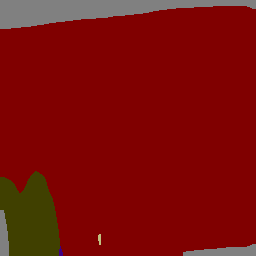

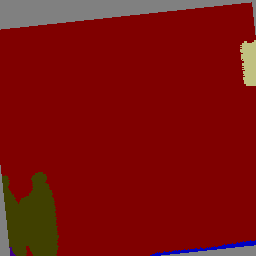

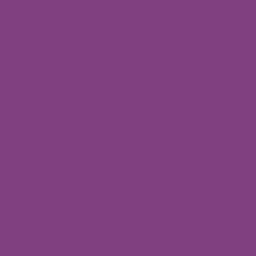

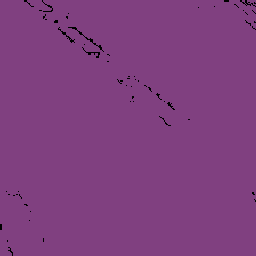

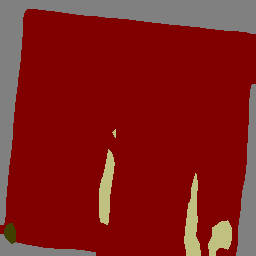

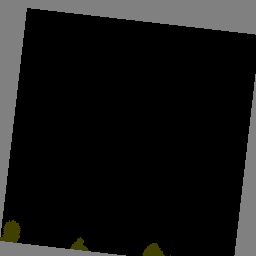

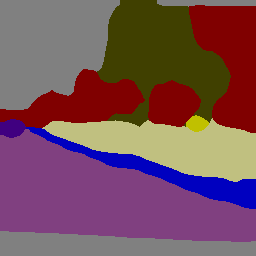

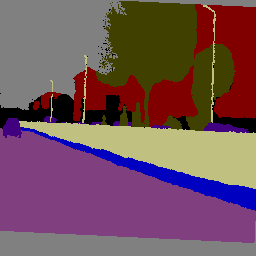

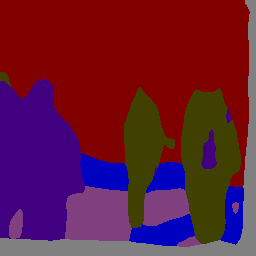

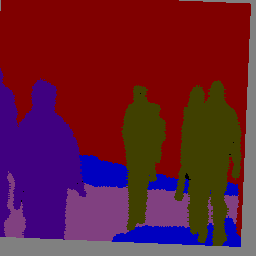

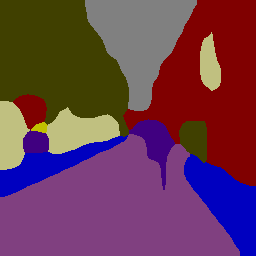

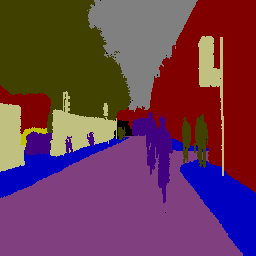

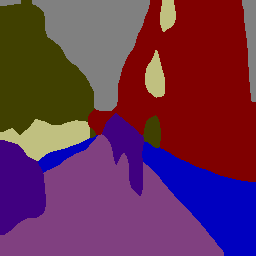

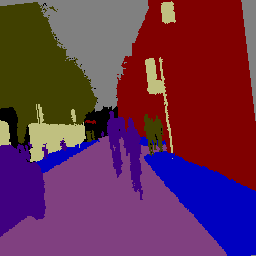

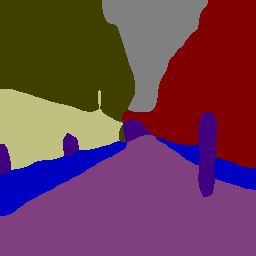

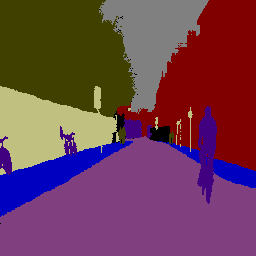

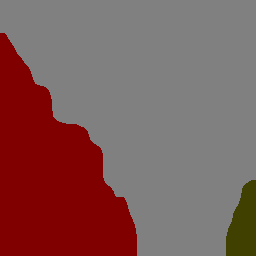

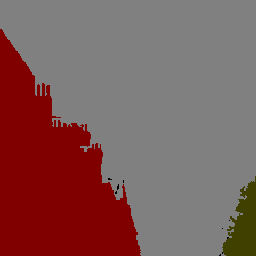

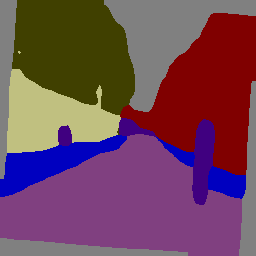

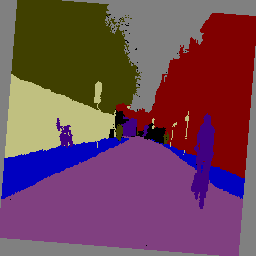

In [ ]:
for i in range(10):
    display(Image.open(os.path.join('/kaggle/working/predictions_colored', f'pred_{i}.png')))
    display(Image.open(os.path.join('/kaggle/working/ground_truth_colored', f'gt_{i}.png')))

# RESULTS

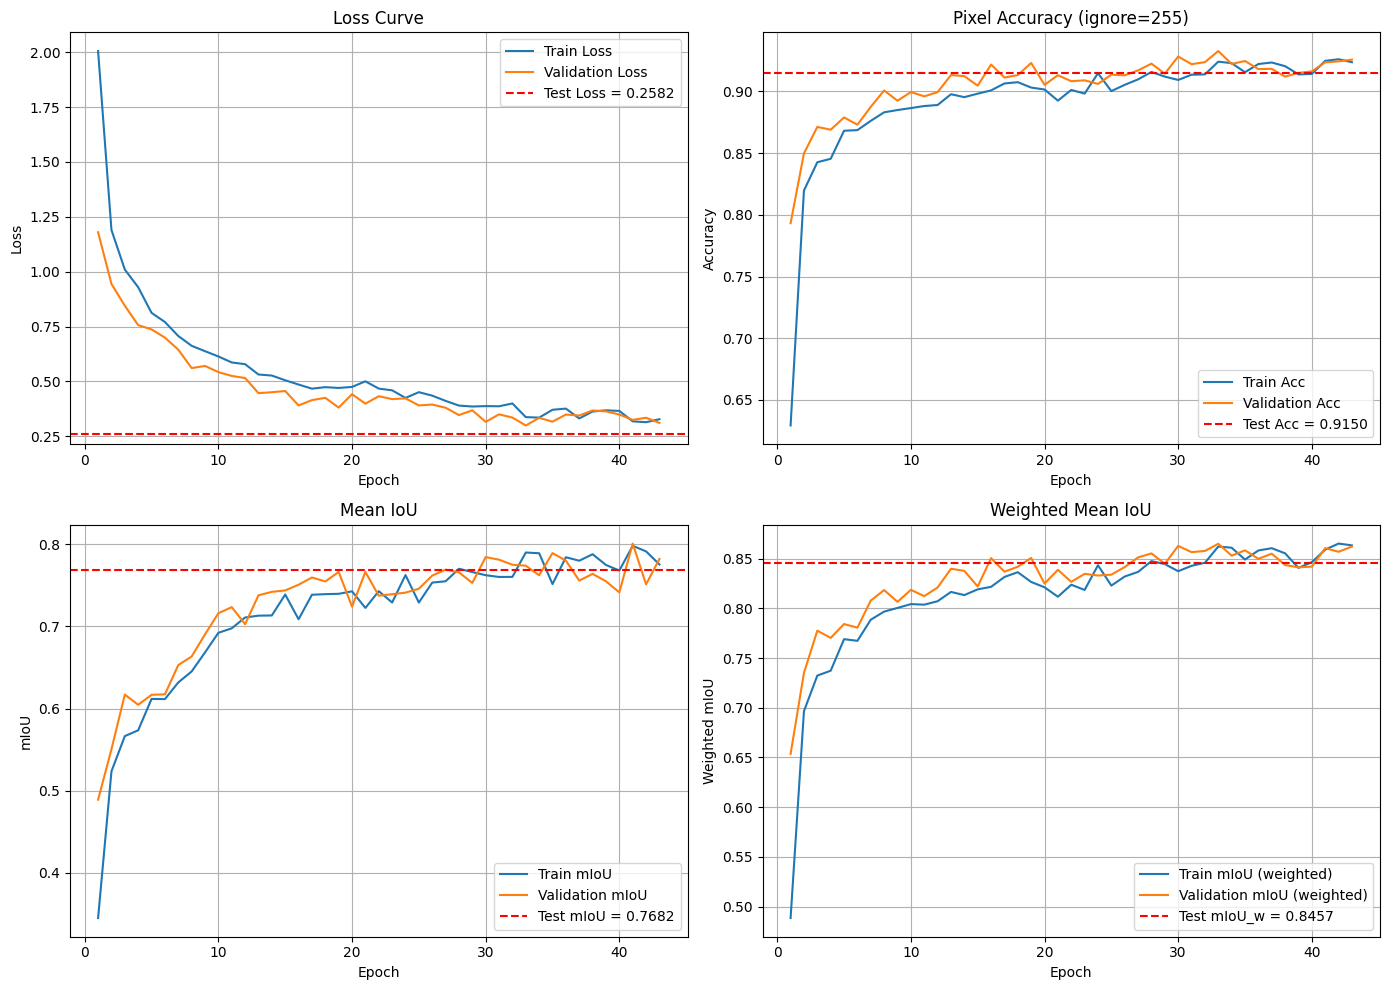

In [ ]:
def _trim_to_min_len(*series):

    seqs = [s for s in series if s is not None]
    if not seqs:
        return ()
    m = min(len(s) for s in seqs)

    return tuple((s[:m] if s is not None else None) for s in series), np.arange(1, m+1)

loss_tr   = history.get('loss', [])
loss_val  = history.get('val_loss', [])
acc_tr    = history.get('accuracy', [])
acc_val   = history.get('val_accuracy', [])
miou_tr   = history.get('train_mIoU', [])
miou_val  = history.get('val_mIoU', [])
wmiou_tr  = history.get('train_mIoU_weighted', [])
wmiou_val = history.get('val_mIoU_weighted', [])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
(ax_loss, ax_acc), (ax_miou, ax_wmiou) = axes

(series, epochs) = _trim_to_min_len(loss_tr, loss_val)
if series:
    tr, val = series
    ax_loss.plot(epochs, tr, label='Train Loss')
    ax_loss.plot(epochs, val, label='Validation Loss')
    if 'test_loss' in globals():
        ax_loss.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss = {test_loss:.4f}')
ax_loss.set_xlabel('Epoch'); ax_loss.set_ylabel('Loss'); ax_loss.set_title('Loss Curve')
ax_loss.grid(True); ax_loss.legend()

(series, epochs) = _trim_to_min_len(acc_tr, acc_val)
if series:
    tr, val = series
    ax_acc.plot(epochs, tr, label='Train Acc')
    ax_acc.plot(epochs, val, label='Validation Acc')
    if 'test_acc' in globals():
        ax_acc.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc = {test_acc:.4f}')
ax_acc.set_xlabel('Epoch'); ax_acc.set_ylabel('Accuracy'); ax_acc.set_title('Pixel Accuracy (ignore=255)')
ax_acc.grid(True); ax_acc.legend()

(series, epochs) = _trim_to_min_len(miou_tr, miou_val)
if series:
    tr, val = series
    ax_miou.plot(epochs, tr, label='Train mIoU')
    ax_miou.plot(epochs, val, label='Validation mIoU')
    if 'test_miou' in globals():
        ax_miou.axhline(y=test_miou, color='r', linestyle='--', label=f'Test mIoU = {test_miou:.4f}')
ax_miou.set_xlabel('Epoch'); ax_miou.set_ylabel('mIoU'); ax_miou.set_title('Mean IoU')
ax_miou.grid(True); ax_miou.legend()

(series, epochs) = _trim_to_min_len(wmiou_tr, wmiou_val)
if series:
    tr, val = series
    ax_wmiou.plot(epochs, tr, label='Train mIoU (weighted)')
    ax_wmiou.plot(epochs, val, label='Validation mIoU (weighted)')
    if 'test_miou_w' in globals():
        ax_wmiou.axhline(y=test_miou_w, color='r', linestyle='--', label=f'Test mIoU_w = {test_miou_w:.4f}')
ax_wmiou.set_xlabel('Epoch'); ax_wmiou.set_ylabel('Weighted mIoU'); ax_wmiou.set_title('Weighted Mean IoU')
ax_wmiou.grid(True); ax_wmiou.legend()

plt.tight_layout()
plt.show()